In [2]:
import re
import os
import json
from pathlib import Path
from typing import Optional
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee', 'no-latex'])
plt.rc("legend", fontsize="small")
plt.rc("xtick.minor", visible=False)

import numpy as np
from coqstoq.check import EvalResults
from edist.sed import standard_sed



In [3]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling":
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [4]:
def load_results(loc: Path) -> EvalResults:
    with loc.open() as fin:
        eval_data = json.load(fin) 
        return EvalResults.from_json(eval_data)


def remove_proof_qed(s: str) -> str:
    return s.replace("Proof.", "").replace("Qed.", "")


def proof_length(s: str) -> int:
    s = remove_proof_qed(s)
    tactics = re.split(r"[.;]\s+", s.strip())
    proof_length = len(tactics)
    if 0 == proof_length:
        print(s)
    assert 0 < proof_length
    return len(tactics)


def fair_edist(s1: str, s2: str) -> int:
    s1 = remove_proof_qed(s1)
    s2 = remove_proof_qed(s2)
    return standard_sed(s1, s2)


In [10]:
HUMAN_LOC = Path("evaluations/human.json")
RANGO_LOC = Path("evaluations/rango-results.json")
PREFIX_LOC = Path("evaluations/prefix-results.json")
TACTICIAN_LOC = Path("evaluations/tactician-results.json")
PROVERBOT_LOC = Path("evaluations/proverbot-results.json")

In [11]:
HUMAN_EVAL = load_results(HUMAN_LOC)
RANGO_EVAL = load_results(RANGO_LOC)
PREFIX_EVAL = load_results(PREFIX_LOC)
TACTICIAN_EVAL = load_results(TACTICIAN_LOC)
PROVERBOT_EVAL = load_results(PROVERBOT_LOC)

## Proofs by Length

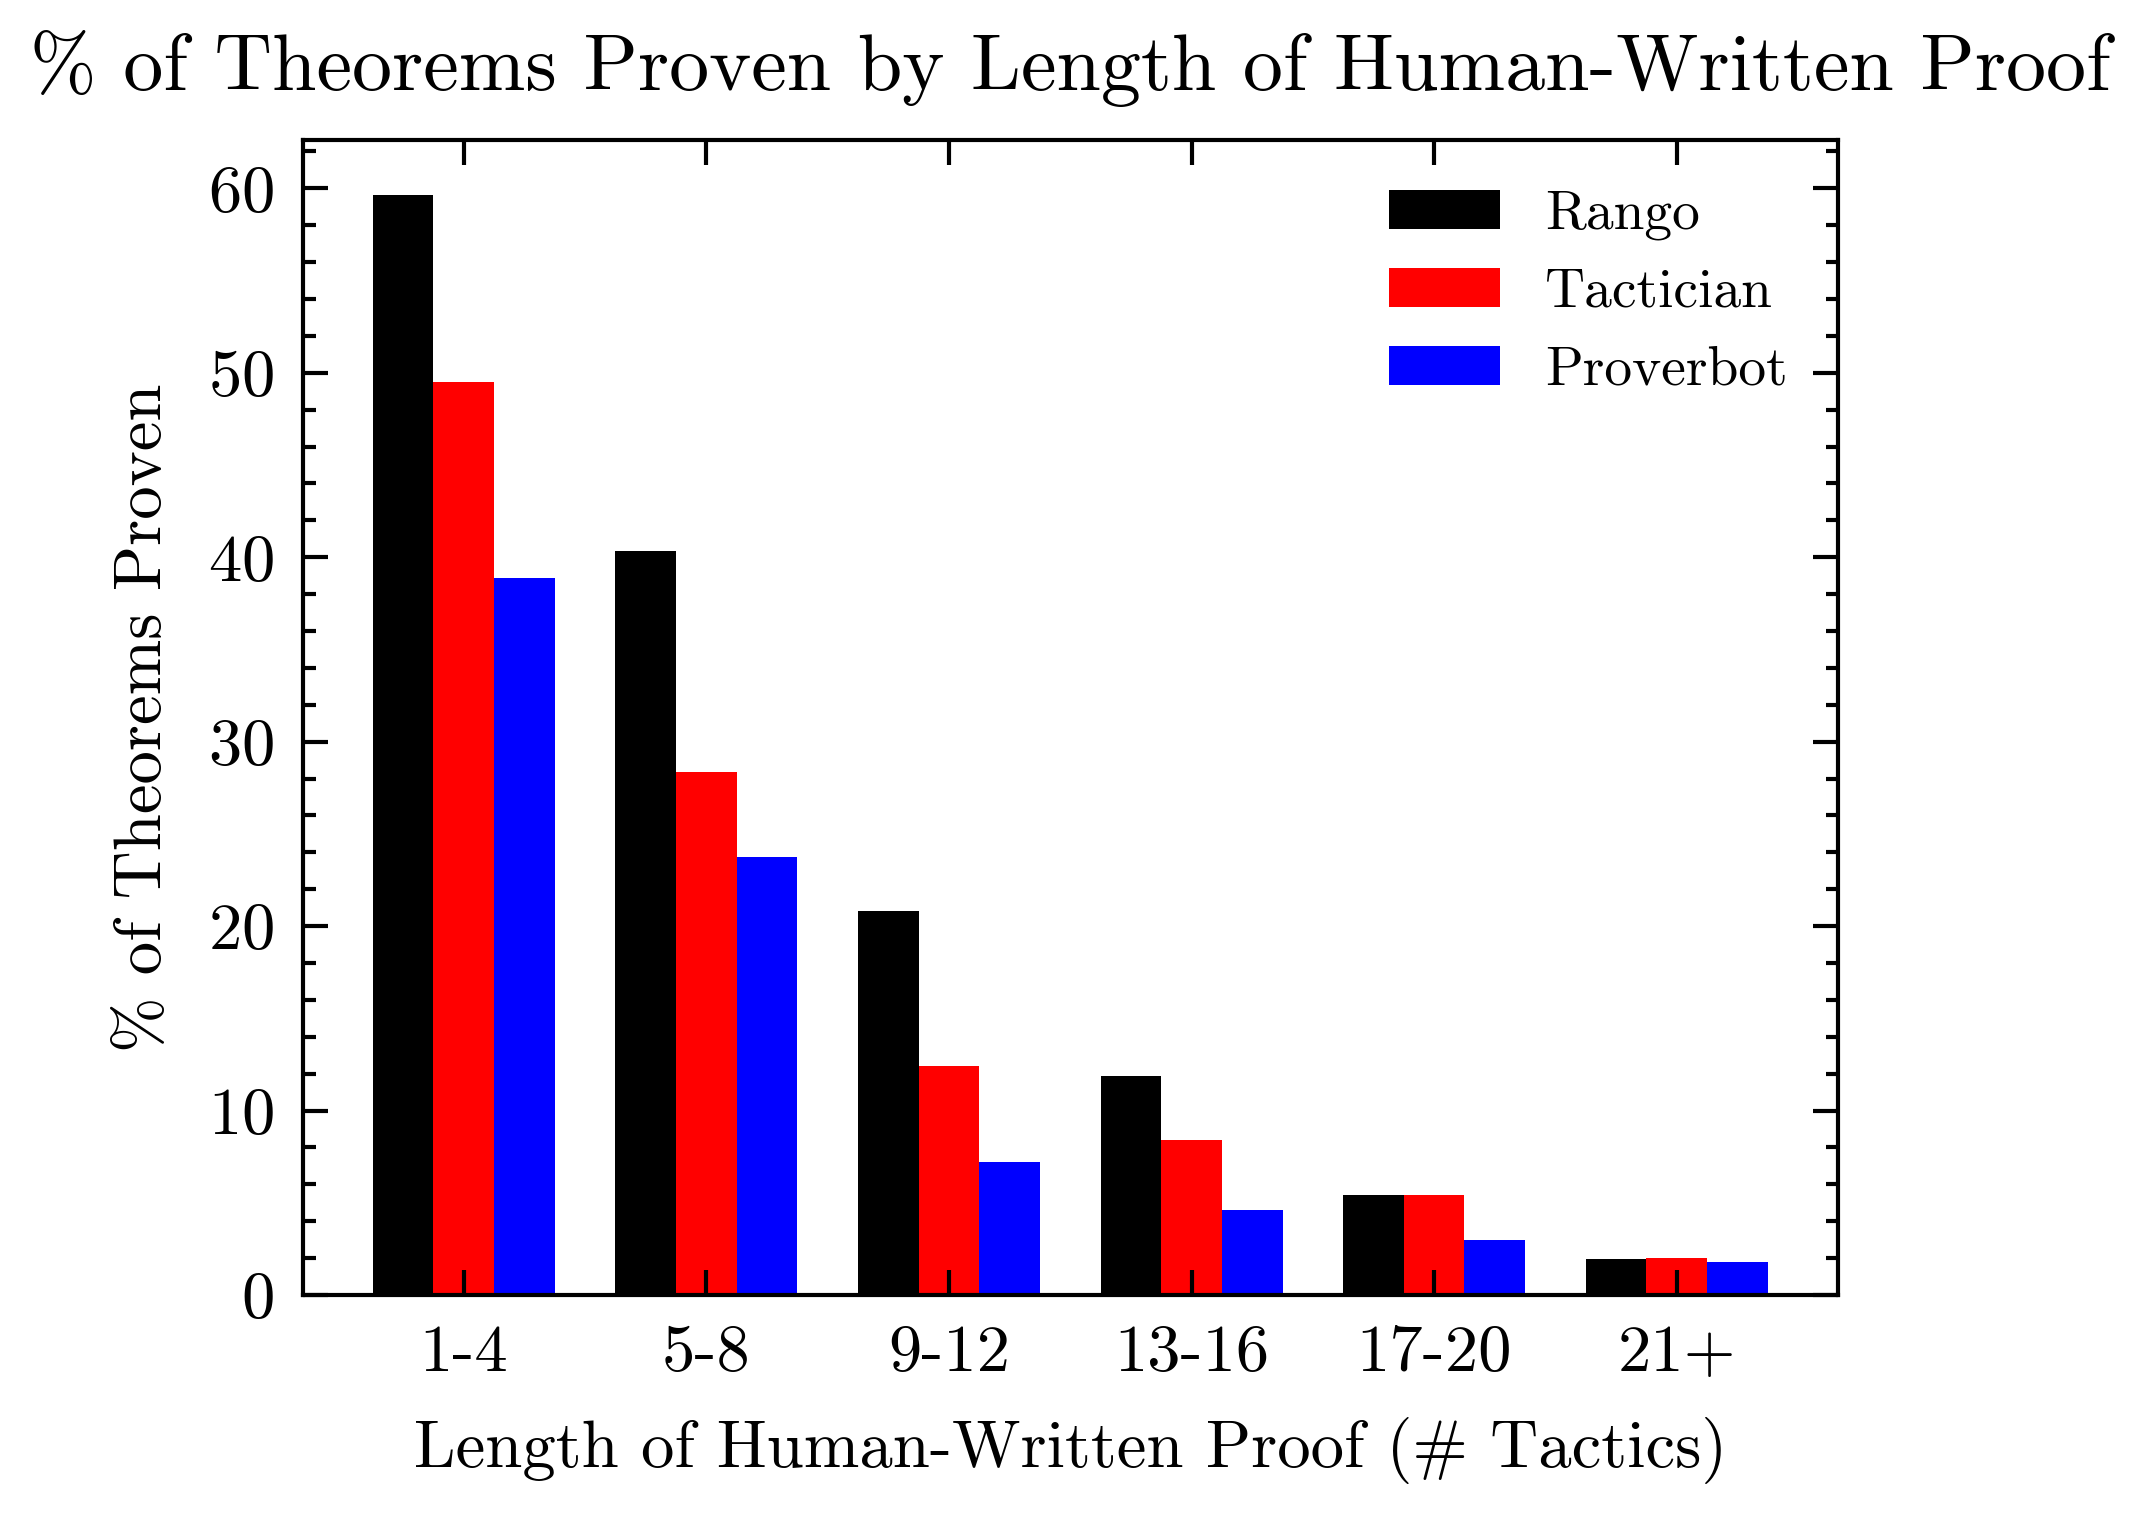

In [7]:
ranges = [
    (1, 4),
    (5, 8),
    (9, 12),
    (13, 16),
    (17, 20),
    (21, None),
]

def assign_ranges(eval_results: EvalResults, options: list[tuple[int, Optional[int]]]) -> list[tuple[int, Optional[int]]]:
    ranges: list[tuple[int, Optional[int]]] = []
    for r in eval_results.results:
        assert r.proof is not None
        found_range = False
        for lo, hi in options:
            if hi is None and lo <= proof_length(r.proof):
                ranges.append((lo, hi))
                found_range = True
                break
            elif hi is not None and lo <= proof_length(r.proof) <= hi:
                ranges.append((lo, hi))
                found_range = True
                break
        assert found_range
    return ranges

def get_success_rates_by_ranges(eval_results: EvalResults, ranges: list[tuple[int, Optional[int]]], timeout: int=600) -> dict[tuple[int, Optional[int]], float]:
    sum_counts: dict[tuple[int, Optional[int]], tuple[int, int]] = {}
    assert len(eval_results.results) == len(ranges)
    for i, r in enumerate(eval_results.results):
        rng = ranges[i]
        if rng not in sum_counts:
            sum_counts[rng] = (0, 0)
        cur_sum, cur_count = sum_counts[rng]
        if r.proof is not None and r.time is not None and r.time < timeout:
            sum_counts[rng] = (cur_sum + 1, cur_count + 1) 
        else:
            sum_counts[rng] = (cur_sum, cur_count + 1)
    
    success_rates: dict[tuple[int, Optional[int]], float] = {}
    for rng, (success, total) in sum_counts.items():
        success_rates[rng] = success / total
    return success_rates

def get_success_list(ranges: list[tuple[int, Optional[int]]], success_rates: dict[tuple[int, Optional[int]], float]) -> list[float]:
    success_list = []
    for rng in ranges:
        success_list.append(success_rates[rng] * 100)
    return success_list

def format_range(rng: tuple[int, Optional[int]]) -> str:
    start, end = rng
    if end is None:
        return f"{start}+"
    return f"{start}-{end}"
    
thm_ranges = assign_ranges(HUMAN_EVAL, ranges)

rango_rates = get_success_rates_by_ranges(RANGO_EVAL, thm_ranges)
tactician_rates = get_success_rates_by_ranges(TACTICIAN_EVAL, thm_ranges)
proverbot_rates = get_success_rates_by_ranges(PROVERBOT_EVAL, thm_ranges)

rango_list = get_success_list(ranges, rango_rates)
tactician_list = get_success_list(ranges, tactician_rates)
proverbot_list = get_success_list(ranges, proverbot_rates)

fig, ax = plt.subplots()
bar_width = 0.25
categories = np.arange(len(ranges))

ax.bar(categories - bar_width, rango_list, width=bar_width, label="Rango")
ax.bar(categories, tactician_list, width=bar_width, label="Tactician")
ax.bar(categories + bar_width, proverbot_list, width=bar_width, label="Proverbot")
ax.set_xticks(categories, minor=False)
ax.set_xticklabels([format_range(r) for r in ranges])


ax.set_title("% of Theorems Proven by Length of Human-Written Proof")
ax.set_ylabel("% of Theorems Proven")
ax.set_xlabel("Length of Human-Written Proof (# Tactics)")
ax.legend()

fig.savefig("evaluations/stuff/success_by_length.pdf")

## Proofs by Dependencies

In [ ]:
DEP_LOC = Path("data/deps.json")

with DEP_LOC.open() as fin:
    deps = json.load(fin)

dep_ranges = [
    (0, 49),
    (50, 99),
    (100, 149),
    (150, 199),
    (200, None),
]

# dep_ranges = [
#     (0, 0), 
#     (1, 10),
#     (11, 20),
#     (21, 30),
#     (31, 40),
#     (41, None),
# ]

def get_sum_counts_by_dep_ranges(eval: EvalResults, ranges: list[tuple[int, Optional[int]]], deps: list[int], timeout: int = 600) -> dict[tuple[int, Optional[int]], tuple[int, int]]:
    assert len(eval.results) == len(deps)
    sum_counts: dict[tuple[int, Optional[int]], tuple[int, int]] = {}
    for i, r in enumerate(eval.results):
        deps_i = deps[i]
        rng_i: Optional[tuple[int, Optional[int]]] = None
        for rng in ranges:
            lo, hi = rng
            if hi is None and lo <= deps_i:
                rng_i = rng
                break
            if hi is not None and lo <= deps_i <= hi:
                rng_i = rng
                break
        assert rng_i is not None
        if rng_i not in sum_counts:
            sum_counts[rng_i] = (0, 0)
        
        cur_sum, cur_count = sum_counts[rng_i]
        if r.proof is not None and r.time is not None and r.time < timeout:
            sum_counts[rng_i] = (cur_sum + 1, cur_count + 1)
        else:
            sum_counts[rng_i] = (cur_sum, cur_count + 1)

        # sum_counts[rng_i] = (cur_sum + proof_length(HUMAN_EVAL.results[i].proof), cur_count + 1)

    return sum_counts

def get_success_rates_by_dep_ranges(eval: EvalResults, ranges: list[tuple[int, Optional[int]]], deps: list[int], timeout: int=600) -> dict[tuple[int, Optional[int]], float]:
    sum_counts = get_sum_counts_by_dep_ranges(eval, ranges, deps, timeout)
    success_rates: dict[tuple[int, Optional[int]], float] = {}
    for rng, (success, total) in sum_counts.items():
        success_rates[rng] = success / total
    return success_rates


def format_range(rng: tuple[int, Optional[int]]) -> str:
    start, end = rng
    if end is None:
        return f"{start}+"
    if start == end:
        return f"{start}"
    return f"{start}-{end}"


def get_success_list(ranges: list[tuple[int, Optional[int]]], success_rates: dict[tuple[int, Optional[int]], float]) -> list[float]:
    success_list = []
    for rng in ranges:
        success_list.append(success_rates[rng] * 100)
    return success_list


rango_dep_rates = get_success_rates_by_dep_ranges(RANGO_EVAL, dep_ranges, deps)
prefix_dep_rates = get_success_rates_by_dep_ranges(PREFIX_EVAL, dep_ranges, deps)
tactician_dep_rates = get_success_rates_by_dep_ranges(TACTICIAN_EVAL, dep_ranges, deps)
proverbot_dep_rates = get_success_rates_by_dep_ranges(PROVERBOT_EVAL, dep_ranges, deps)

rango_dep_list = get_success_list(dep_ranges, rango_dep_rates)
prefix_dep_list = get_success_list(dep_ranges, prefix_dep_rates)
tactician_dep_list = get_success_list(dep_ranges, tactician_dep_rates)
proverbot_dep_list = get_success_list(dep_ranges, proverbot_dep_rates)


fig, ax = plt.subplots()
bar_width = 0.25
categories = np.arange(len(dep_ranges))


ax.bar(categories - bar_width, rango_dep_list, width=bar_width, label="Rango")
ax.bar(categories, tactician_dep_list, width=bar_width, label="Tactician")
ax.bar(categories + bar_width, proverbot_dep_list, width=bar_width, label="Proverbot")
ax.set_xticks(categories)
ax.set_xticklabels([format_range(r) for r in dep_ranges])

# ax.bar(categories - bar_width, rango_dep_list, width=bar_width, label="Rango")
# ax.bar(categories, prefix_dep_list, width=bar_width, label="Prefix")
# ax.bar(categories + bar_width, tactician_dep_list, width=bar_width, label="Tactician")
# ax.set_xticks(categories)
# ax.set_xticklabels([format_range(r) for r in dep_ranges])


ax.set_title("% of Theorems Proven by # of Dependencies")
ax.set_ylabel("% of Theorems Proven")
ax.set_xlabel("# of Dependencies")
ax.legend()

fig.savefig("evaluations/stuff/proofs_by_deps.pdf")


In [8]:
two_ranges = [
    (0, 10),
    (11, None),
]

rango_sum_counts = get_sum_counts_by_dep_ranges(RANGO_EVAL, two_ranges, deps)
tactician_sum_counts = get_sum_counts_by_dep_ranges(TACTICIAN_EVAL, two_ranges, deps)
proverbot_sum_counts = get_sum_counts_by_dep_ranges(PROVERBOT_EVAL, two_ranges, deps)

print(rango_sum_counts)
print(tactician_sum_counts)
print(proverbot_sum_counts)


{(11, None): (1911, 6327), (0, 10): (1414, 4069)}
{(11, None): (1437, 6327), (0, 10): (1138, 4069)}
{(11, None): (1131, 6327), (0, 10): (876, 4069)}


In [9]:
(1414 - 876) / 876 

0.6141552511415526

In [10]:
(1911 - 1131) / 1131

0.6896551724137931

In [11]:
(1610 - 1187) / 1187

0.35636057287278855

In [12]:
(1715 - 1025) / 1025

0.6731707317073171

In [13]:
(1610 - 982) / 982

0.639511201629328

## Proof Length

In [14]:

import statistics

def find_mutual_proofs(results_list: list[EvalResults], timeout: int=600) -> list[int]:
    all_succeed_indices: list[int] = []
    assert 0 < len(results_list)
    results_num = len(results_list[0].results)
    for i in range(results_num):
        all_succeed = True
        for r_list in results_list:
            assert i < len(r_list.results)
            result_i = r_list.results[i]
            if result_i.proof is None or result_i.time is None or timeout <= result_i.time:
                all_succeed = False
                break
        if all_succeed:
            all_succeed_indices.append(i)
    return all_succeed_indices


def get_proof_lengths(eval: EvalResults, indices: list[int]) -> list[int]:
    proof_lengths: list[int] = []
    for i in indices:
        assert i < len(eval.results)
        result_i = eval.results[i]
        assert result_i.proof is not None
        proof_lengths.append(proof_length(result_i.proof))
    return proof_lengths


mutual_idxs = find_mutual_proofs([RANGO_EVAL, TACTICIAN_EVAL, PROVERBOT_EVAL])
human_lengths = get_proof_lengths(HUMAN_EVAL, mutual_idxs)
rango_lengths = get_proof_lengths(RANGO_EVAL, mutual_idxs)
tactician_lengths = get_proof_lengths(TACTICIAN_EVAL, mutual_idxs)
proverbot_lengths = get_proof_lengths(PROVERBOT_EVAL, mutual_idxs)

print("Human", "mean:", statistics.mean(human_lengths), "median:", statistics.median(human_lengths))
print("Rango", "mean:", statistics.mean(rango_lengths), "median:", statistics.median(rango_lengths))
print("Tactician", "mean:", statistics.mean(tactician_lengths), "median:", statistics.median(tactician_lengths))
print("Proverbot", "mean:", statistics.mean(proverbot_lengths), "median:", statistics.median(proverbot_lengths))

Human mean: 3.977635782747604 median: 3.0
Rango mean: 4.537539936102236 median: 4.0
Tactician mean: 4.555910543130991 median: 3.0
Proverbot mean: 6.682907348242812 median: 6.0


In [15]:
len(mutual_idxs)

1252

## Proof Edit Dist

In [16]:
def get_edists(eval: EvalResults, human_eval: EvalResults, indices: list[int]) -> list[float]:
    edists: list[float] = []
    for i in indices:
        assert i < len(eval.results)
        result_i = eval.results[i]
        assert i < len(human_eval.results)
        human_i = human_eval.results[i]
        assert result_i.proof is not None
        assert human_i.proof is not None
        edists.append(fair_edist(result_i.proof, human_i.proof) * 1.0)
    return edists

mutual_idxs = find_mutual_proofs([RANGO_EVAL, TACTICIAN_EVAL, PROVERBOT_EVAL])
rango_edists = get_edists(RANGO_EVAL, HUMAN_EVAL, mutual_idxs)
tactician_edists = get_edists(TACTICIAN_EVAL, HUMAN_EVAL, mutual_idxs)
proverbot_edists = get_edists(PROVERBOT_EVAL, HUMAN_EVAL, mutual_idxs)

print("Rango", "mean:", statistics.mean(rango_edists), "median:", statistics.median(rango_edists))
print("Tactician", "mean:", statistics.mean(tactician_edists), "median:", statistics.median(tactician_edists))
print("Proverbot", "mean:", statistics.mean(proverbot_edists), "median:", statistics.median(proverbot_edists))

Rango mean: 39.68210862619808 median: 23.0
Tactician mean: 52.75798722044728 median: 37.0
Proverbot mean: 61.24041533546326 median: 48.0


## Rango Only

In [15]:
def find_first_only(results_list: list[EvalResults], timeout: int=600) -> list[int]:
    all_succeed_indices: list[int] = []
    assert 0 < len(results_list)
    fst, *rest = results_list
    results_num = len(fst.results)
    for i in range(results_num):
        fst_result = fst.results[i]
        if fst_result.proof is None or fst_result.time is None or timeout <= fst_result.time:
            continue
        all_failed = True
        for r_list in rest:
            assert i < len(r_list.results)
            result_i = r_list.results[i]
            if result_i.proof is not None and result_i.time is not None and result_i.time < timeout:
                all_failed = False
                break
        if all_failed:
            all_succeed_indices.append(i)
    return all_succeed_indices


def get_human_lengths(eval: EvalResults, indices: list[int]) -> list[int]:
    proof_lengths: list[int] = []
    for i in indices:
        assert i < len(eval.results)
        result_i = eval.results[i]
        assert result_i.proof is not None
        proof_lengths.append(proof_length(result_i.proof))
    return proof_lengths


In [16]:
rango_only = find_first_only([RANGO_EVAL, TACTICIAN_EVAL, PROVERBOT_EVAL, PREFIX_EVAL])
lengths = get_human_lengths(HUMAN_EVAL, rango_only)
arg_sorted_lengths: list[int] = list(np.argsort(lengths))

In [ ]:

from coqstoq.eval_thms import EvalTheorem

def get_thm_hash(thm: EvalTheorem) -> str:
    return f"{thm.project.workspace.name}/{thm.path}/{thm.theorem_start_pos.line}-{thm.theorem_start_pos.column}"

good_thms: dict[str, int] = {}
new_idxs: list[int] = []

for i in arg_sorted_lengths[::-1][:100]:
    hproof = HUMAN_EVAL.results[rango_only[i]].proof
    rproof = RANGO_EVAL.results[rango_only[i]].proof
    assert hproof is not None
    assert rproof is not None

    edist = fair_edist(hproof, rproof)
    if edist < 10:
        continue

    if proof_length(hproof) < 6:
        continue

    result = HUMAN_EVAL.results[rango_only[i]]
    print(f"HUMAN PROOF: {rango_only[i]}; {result.thm.project.workspace.name}; {result.thm.path}; {result.thm.theorem_start_pos.line}")
    print(HUMAN_EVAL.results[rango_only[i]].proof)
    print(f"RANGO PROOF: {rango_only[i]}")
    print(RANGO_EVAL.results[rango_only[i]].proof)
    print()
# print(good_thms)
print(list(good_thms.keys()))

['compcert/lib/Integers.v/1552-0', 'ext-lib/theories/Data/HList.v/264-2', 'compcert/common/Values.v/1812-0', 'compcert/cfrontend/SimplLocalsproof.v/1640-0', 'compcert/backend/CSEdomain.v/167-0', 'buchberger/theories/Term.v/410-0', 'compcert/backend/SelectDivproof.v/723-0', 'huffman/theories/AuxLib.v/176-0', 'huffman/theories/Weight.v/157-0', 'huffman/theories/Frequency.v/280-0', 'ext-lib/theories/Data/HList.v/453-4', 'zfc/zfc.v/1468-0', 'compcert/lib/FSetAVLplus.v/348-0', 'buchberger/theories/Term.v/309-0', 'compcert/lib/FSetAVLplus.v/394-0', 'compcert/x86/ConstpropOpproof.v/672-0', 'compcert/lib/Heaps.v/417-0', 'compcert/backend/Asmgenproof0.v/257-0', 'compcert/lib/Heaps.v/218-0', 'huffman/theories/PBTree.v/692-0', 'compcert/common/Values.v/1177-0', 'zfc/Axioms.v/66-0', 'compcert/backend/ValueDomain.v/1811-0', 'compcert/cfrontend/Ctyping.v/1896-0', 'zfc/Ordinal_theory.v/85-0', 'huffman/theories/CoverMin.v/52-0', 'compcert/backend/ValueDomain.v/3612-0', 'huffman/theories/WeightTree.v/7

In [20]:
list(range(len(lengths)) lengths

SyntaxError: '(' was never closed (2455053138.py, line 1)

In [30]:
np.mean(rango_edists)

39.68210862619808

In [ ]:
rango_got = 